**Importación de librerias**

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_recall_curve
)
from xgboost import XGBClassifier
import joblib # Para guardar los modelos finales
import seaborn as sns
import matplotlib.pyplot as plt

**1. CARGA Y PARTICIÓN DE LOS DATOS**

C:\Users\ChristianPE\AppData\Local\Temp\ipykernel_19024\779202790.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


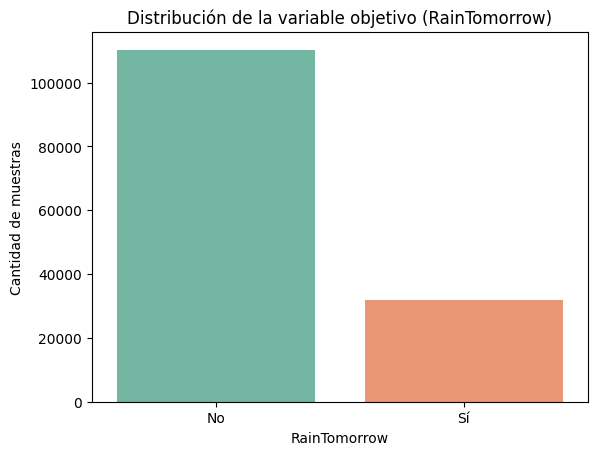

In [11]:
# Ruta del dataset
PATH_CSV = "weatherAUS.csv"
# Variable objetivo (binaria)
TARGET   = "RainTomorrow"

# 1.1 Cargar CSV
df = pd.read_csv(PATH_CSV)

# 1.2 Eliminar filas sin etiqueta
df.dropna(subset=[TARGET], inplace=True)

# 1.3 Separar X (features) e y (target)
X = df.drop(columns=[TARGET])

# Si es cadena -> map a 0/1
y = (df[TARGET]
   .map({"No": 0, "Yes": 1}) if df[TARGET].dtype == "O" else df[TARGET])

# 1.4 Train / Test / Valid (70 % / 10 % / 20 %)
X_train, X_test, y_train, y_test = train_test_split(
   X, y, stratify=y, test_size=0.20, random_state=42
)
X_train, X_val,  y_train, y_val  = train_test_split(
   X_train, y_train, stratify=y_train, test_size=0.10, random_state=42
)

# GRAFICOS
sns.countplot(x=y, palette="Set2")
plt.title("Distribución de la variable objetivo (RainTomorrow)")
plt.xticks([0, 1], ["No", "Sí"])
plt.ylabel("Cantidad de muestras")
plt.show()


**2. PIPELINE DE PRE-PROCESADO**

In [3]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

numeric_pipe = Pipeline([
   ("imputer", SimpleImputer(strategy="median")),  # imputa con mediana
   ("scaler",  StandardScaler())                  # escala N(0,1)
])

categoric_pipe = Pipeline([
   ("imputer", SimpleImputer(strategy="most_frequent")), # imputa con moda
   ("encoder", OneHotEncoder(handle_unknown="ignore"))   # one-hot
])

preproc = ColumnTransformer([
   ("num", numeric_pipe, num_cols),
   ("cat", categoric_pipe, cat_cols)
])

**3. DEFINICIÓN DE DOS MODELOS *XGBoost***
   - Modelo_A: privilegia precisión
   - Modelo_B: privilegia recall

In [ ]:
# desequilibrio clases
ratio = (y_train == 0).sum() / (y_train == 1).sum()

model_A = XGBClassifier(
   objective        ="binary:logistic",
   eval_metric      ="logloss",
   scale_pos_weight = ratio,   # equilibra clases
   learning_rate    = 0.05,
   n_estimators     = 800,
   max_depth        = 5,
   subsample        = 0.9,
   colsample_bytree = 0.8,
   min_child_weight = 5,
   reg_lambda       = 1.0,
   random_state     = 42
)

model_B = XGBClassifier(
   objective        ="binary:logistic",
   eval_metric      ="logloss",
   scale_pos_weight = ratio * 1.5,  # aún más peso a la clase 1
   learning_rate    = 0.03,
   n_estimators     = 1200,
   max_depth        = 6,
   subsample        = 0.8,
   colsample_bytree = 0.8,
   min_child_weight = 1,
   reg_lambda       = 1.0,
   random_state     = 43
)


**4. ENTRENAMIENTO CON PIPELINES**

In [5]:
pipe_A = Pipeline([("prep", preproc), ("clf", model_A)])
pipe_B = Pipeline([("prep", preproc), ("clf", model_B)])

pipe_A.fit(X_train, y_train)
pipe_B.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


*4.1 Guardar modelos si se desea*

In [6]:
joblib.dump(pipe_A, "xgb_precision.pkl")
joblib.dump(pipe_B, "xgb_recall.pkl")

['xgb_recall.pkl']

**5. ENSAMBLE Y SELECCIÓN DE UMBRAL EN VALIDACIÓN**

Umbral óptimo = 0.699  |  F1(val) = 0.6718


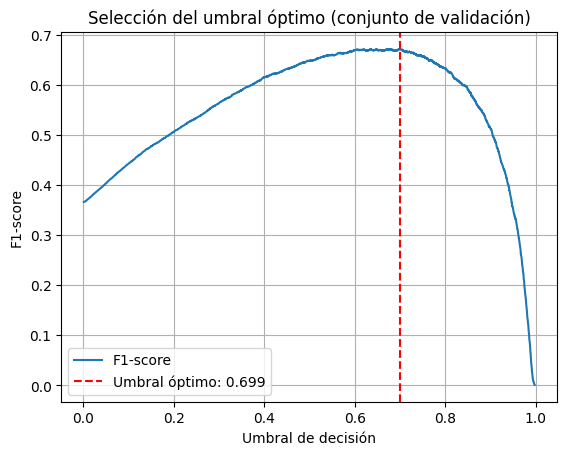

In [ ]:
proba_A = pipe_A.predict_proba(X_val)[:, 1]
proba_B = pipe_B.predict_proba(X_val)[:, 1]

# Ponderación (0.5 / 0.5);
w_A, w_B = 0.5, 0.5
proba_ens = (w_A * proba_A + w_B * proba_B) / (w_A + w_B)

# Se toma el umbral que maximiza F1
prec, rec, thrs = precision_recall_curve(y_val, proba_ens)
f1s = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.nanargmax(f1s)
best_thr = thrs[best_idx]
print(f"Umbral óptimo = {best_thr:.3f}  |  F1(val) = {f1s[best_idx]:.4f}")

# GRAFICO
plt.plot(thrs, f1s[:-1], label="F1-score")
plt.axvline(x=best_thr, color="red", linestyle="--", label=f"Umbral óptimo: {best_thr:.3f}")
plt.xlabel("Umbral de decisión")
plt.ylabel("F1-score")
plt.title("Selección del umbral óptimo (conjunto de validación)")
plt.legend()
plt.grid()
plt.show()


**6. EVALUACIÓN FINAL EN TEST**


MÉTRICAS EN CONJUNTO DE PRUEBA
              precision    recall  f1-score   support

           0      0.902     0.914     0.908     22064
           1      0.687     0.657     0.672      6375

    accuracy                          0.856     28439
   macro avg      0.795     0.785     0.790     28439
weighted avg      0.854     0.856     0.855     28439

Matriz de confusión:
 [[20159  1905]
 [ 2189  4186]]


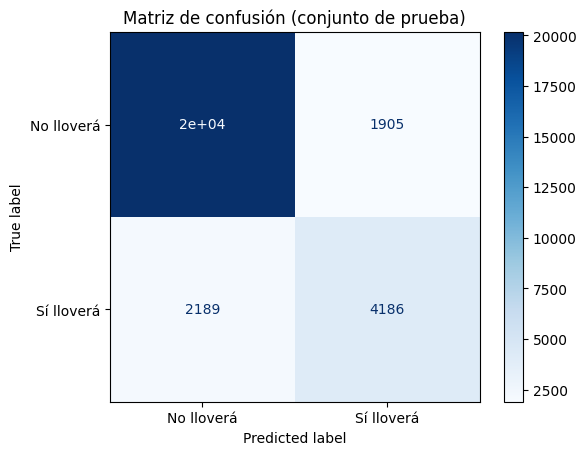

C:\Users\ChristianPE\AppData\Local\Temp\ipykernel_19024\62554831.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp_df.values, y=feat_imp_df.index, palette="viridis")


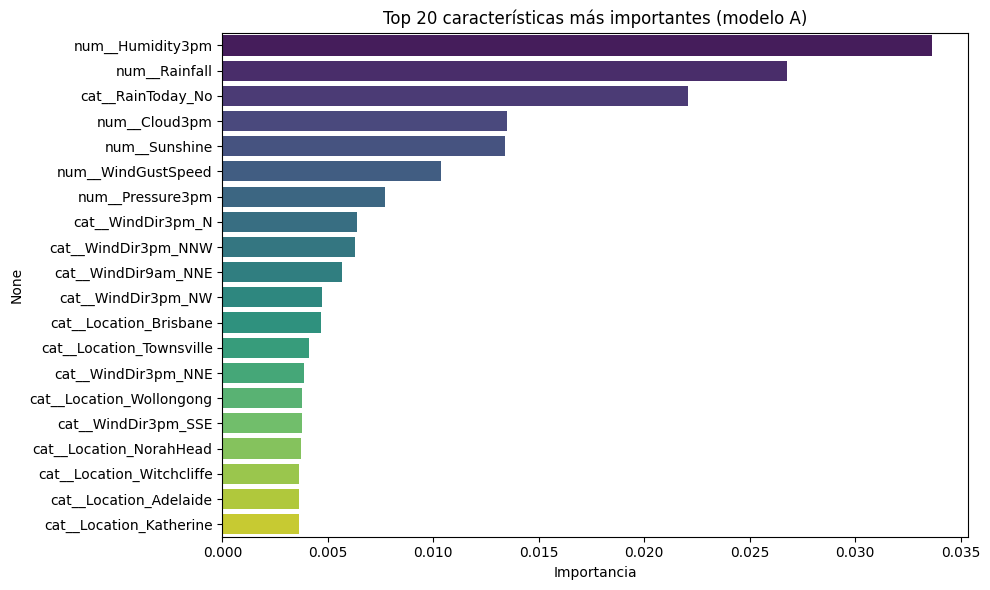

In [14]:
proba_test = (w_A * pipe_A.predict_proba(X_test)[:, 1] +
              w_B * pipe_B.predict_proba(X_test)[:, 1]) / (w_A + w_B)

y_pred = (proba_test >= best_thr).astype(int)

print("\nMÉTRICAS EN CONJUNTO DE PRUEBA")
print(classification_report(y_test, y_pred, digits=3))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

# GRAFICO
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["No lloverá", "Sí lloverá"],
    cmap="Blues",
    normalize=None
)
plt.title("Matriz de confusión (conjunto de prueba)")
plt.show()

importances = model_A.feature_importances_
features_encoded = pipe_A.named_steps["prep"].get_feature_names_out()
feat_imp_df = pd.Series(importances, index=features_encoded).sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp_df.values, y=feat_imp_df.index, palette="viridis")
plt.title("Top 20 características más importantes (modelo A)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

